Chris has
* Initiated 8 crosses ("randomly sporulated about 1000 (+/-300) spores per cross (8 crosses)")
* Mapped the reads and did some preliminary coverage / allele frequency plots

Files are on /home/ceberlein/02_ANALYSES/02_TRD/ and /Volumes/SRV-FILE-JS/Projects/TransmissionRatioDistortion_TransPOP_ChrisEberlein

In [1]:
# He aligned with bwa mem and sorted the files with samtools, both default options
dir(path="/home/ceberlein/02_ANALYSES/02_TRD/01_Alignment_to_REF/", ".sorted.bam$")

[1] "TRDC01ACPxBFP.sorted.bam" "TRDC02BAPxCMP.sorted.bam"
[3] "TRDC03CCDxCPG.sorted.bam" "TRDC04ATExYCR.sorted.bam"
[5] "TRDC05ACKxACV.sorted.bam" "TRDC06AKExBAH.sorted.bam"
[7] "TRDC07BAHxCGD.sorted.bam" "TRDC08ANGxCEI.sorted.bam"

In [2]:
library(data.table)

In [3]:
#The coverage files are output from samtools depth
dir(path="/home/ceberlein/02_ANALYSES/02_TRD/01_Alignment_to_REF/", "coverage$")

#they are aggregated into
df_coverage_chris<-fread("/home/ceberlein/02_ANALYSES/02_TRD/02_Coverage_AlleleFreq/Coverage_TRD_Scerevisiae.csv", data.table = FALSE)
head(df_coverage_chris)

[1] "TRDC01ACPxBFP.coverage" "TRDC02BAPxCMP.coverage" "TRDC03CCDxCPG.coverage"
[4] "TRDC04ATExYCR.coverage" "TRDC05ACKxACV.coverage" "TRDC06AKExBAH.coverage"
[7] "TRDC07BAHxCGD.coverage" "TRDC08ANGxCEI.coverage"

chrom       species                Start Stop  length_chromosome
1 chromosome1 TRDC01ACPxBFP.coverage     1 10000 230218           
2 chromosome1 TRDC01ACPxBFP.coverage 10001 20000 230218           
3 chromosome1 TRDC01ACPxBFP.coverage 20001 30000 230218           
4 chromosome1 TRDC01ACPxBFP.coverage 30001 40000 230218           
5 chromosome1 TRDC01ACPxBFP.coverage 40001 50000 230218           
6 chromosome1 TRDC01ACPxBFP.coverage 50001 60000 230218           
  sub_window_mean_converage sub_window_median_converage
1  78.08585                  70                        
2  33.99335                  15                        
3  54.09782                  45                        
4 133.76918                 134                        
5 101.82818                  98                        
6  88.42344                  86

In [4]:
library(ggplot2)
library(naturalsort)

In [5]:
df_coverage_chris$chrom_fct=factor(df_coverage_chris$chrom, levels=naturalsort(unique(df_coverage_chris$chrom)))

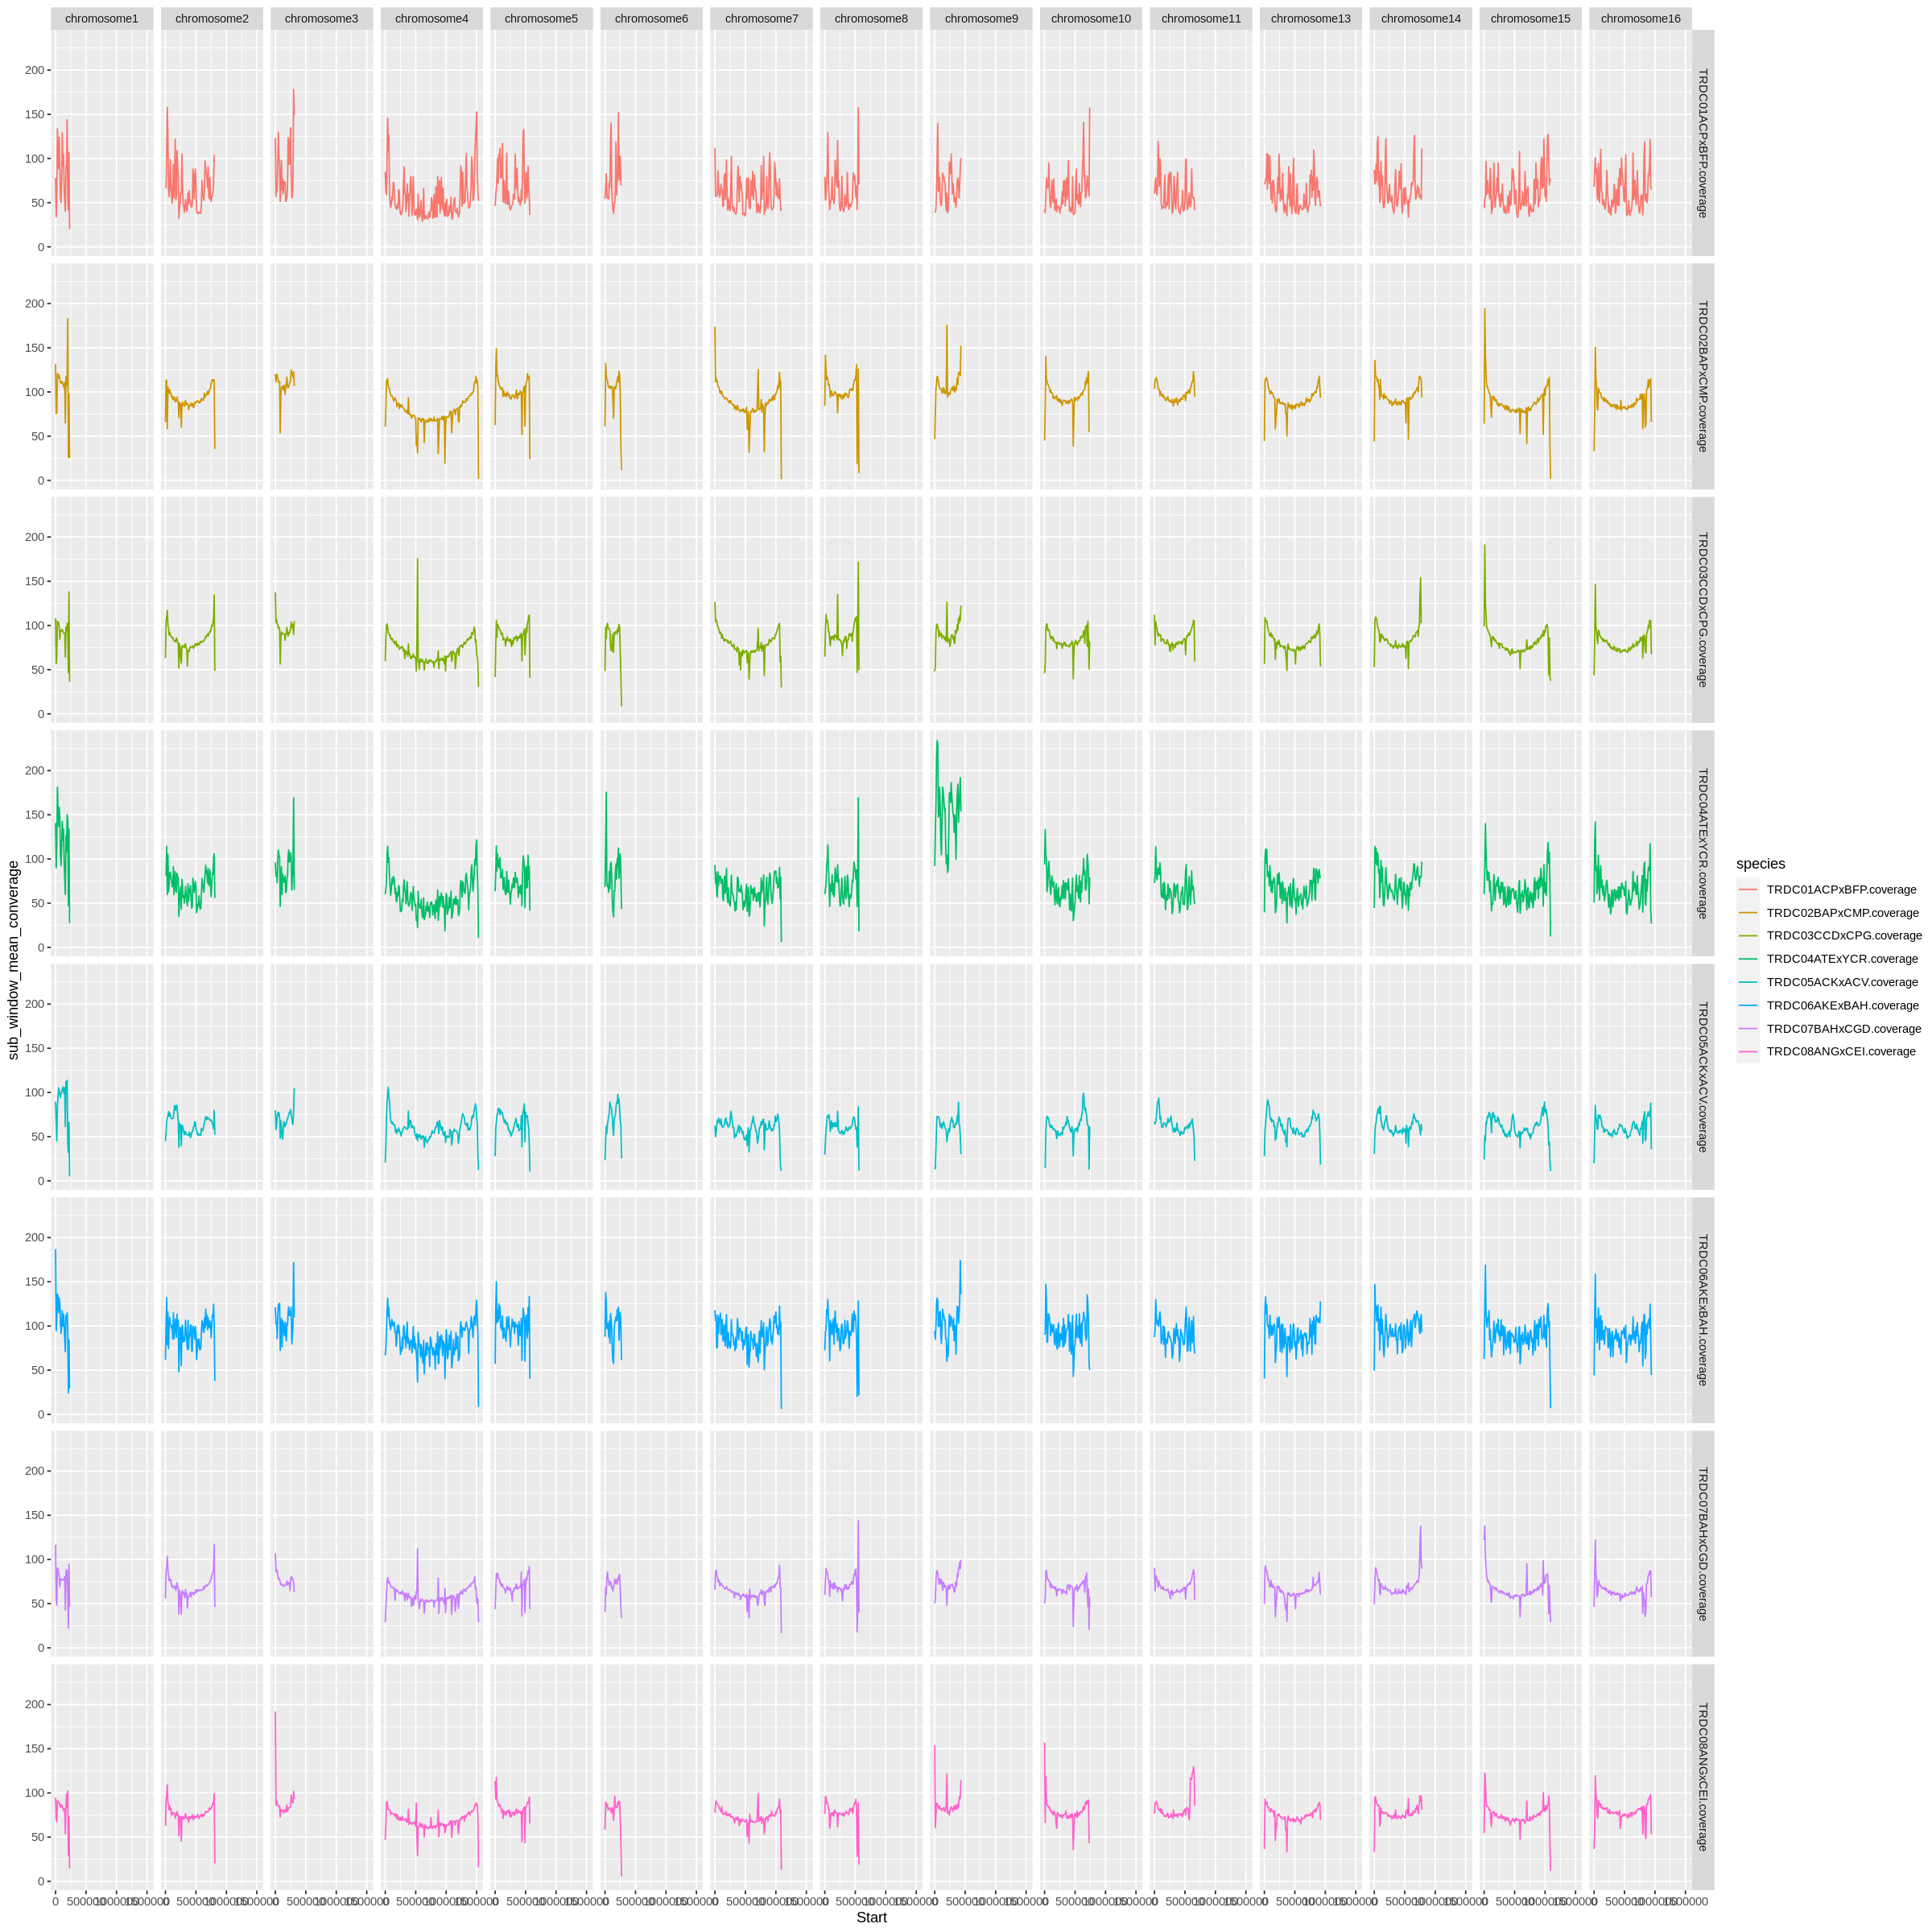

In [6]:
options(repr.plot.width=20, repr.plot.height=20)

df_coverage_chris_plot=subset(df_coverage_chris, !(chrom %in% c("chromosome12","chromosome17")))

ggplot(df_coverage_chris_plot, aes(Start,sub_window_mean_converage,color=species))+
geom_line()+
facet_grid(cols=vars(chrom_fct),rows=vars(species))

There are also vcfs and AF plots, but I cannot find the scripts that generated them.

In [7]:
library(vcfR)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




In [8]:
vcf <- read.vcfR("ceberlein_data/1_ACPxBFP.vcf", verbose = FALSE )

In [9]:
AD <- extract.gt(vcf, element = 'AD', as.numeric = FALSE)

In [10]:
getPart=function(x,which){
    return(as.numeric(strsplit(x, split = ",", fixed = TRUE)[[1]][which]))
}

In [11]:
AD1 = unlist(lapply(AD, getPart, which=1))
AD2 = unlist(lapply(AD, getPart, which=2))

In [12]:
AlleleFrequency=AD1/(AD1+AD2)

In [13]:
MQ <- extract.info(vcf, element = 'MQ', as.numeric = TRUE)
head(MQ)

[1] 32.48 34.07 26.75 26.54 26.63 26.91

In [14]:
df=data.frame(POS=vcfR::getPOS(vcf), CHROM=vcfR::getCHROM(vcf), AF=AlleleFrequency, MQ=MQ)

In [15]:
# scale pos
for(c in unique(df$CHROM)){
    df$POS_scale[df$CHROM==c]=df$POS[df$CHROM==c]/max(df$POS[df$CHROM==c],na.rm=TRUE)
    df$MQ_scale[df$CHROM==c]=df$MQ[df$CHROM==c]-mean(df$MQ[df$CHROM==c],na.rm=TRUE)
    
    df$MQ_scale2[df$CHROM==c]=scale(df$MQ[df$CHROM==c])
}

Warning message:
"Removed 11 rows containing missing values (geom_point)."


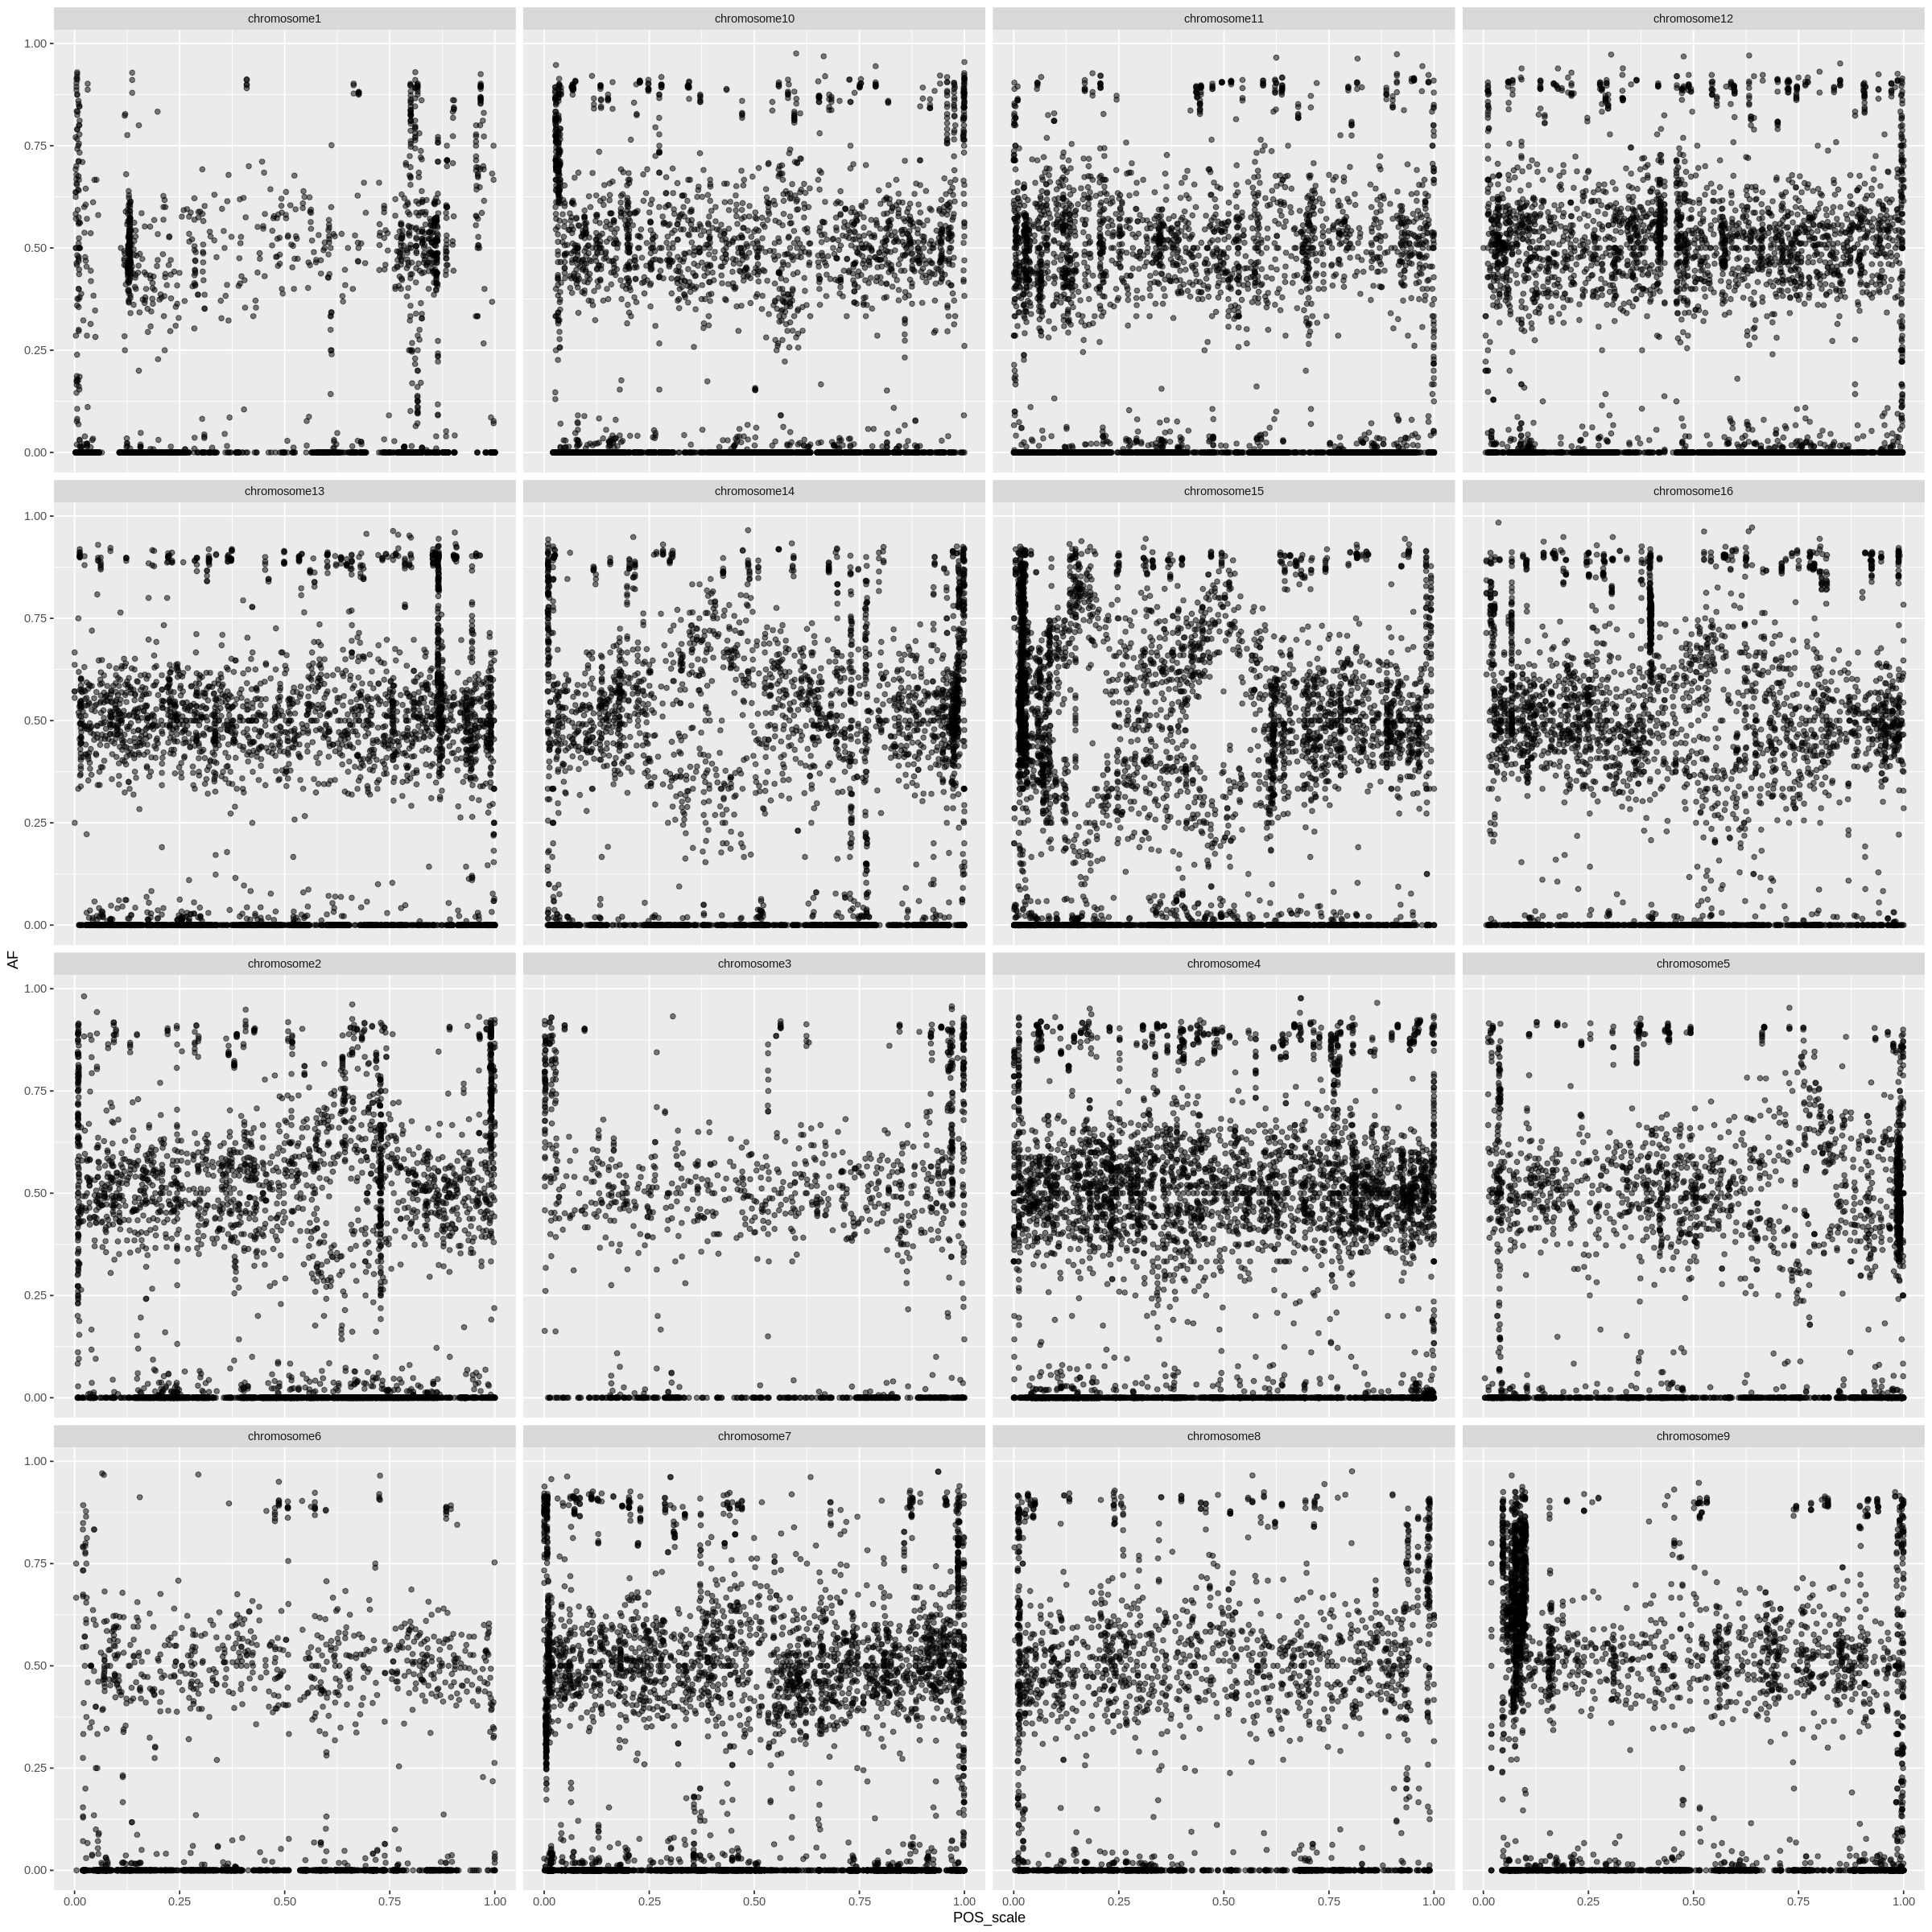

In [16]:
ggplot(df, aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)

Warning message:
"Removed 1 rows containing missing values (geom_point)."


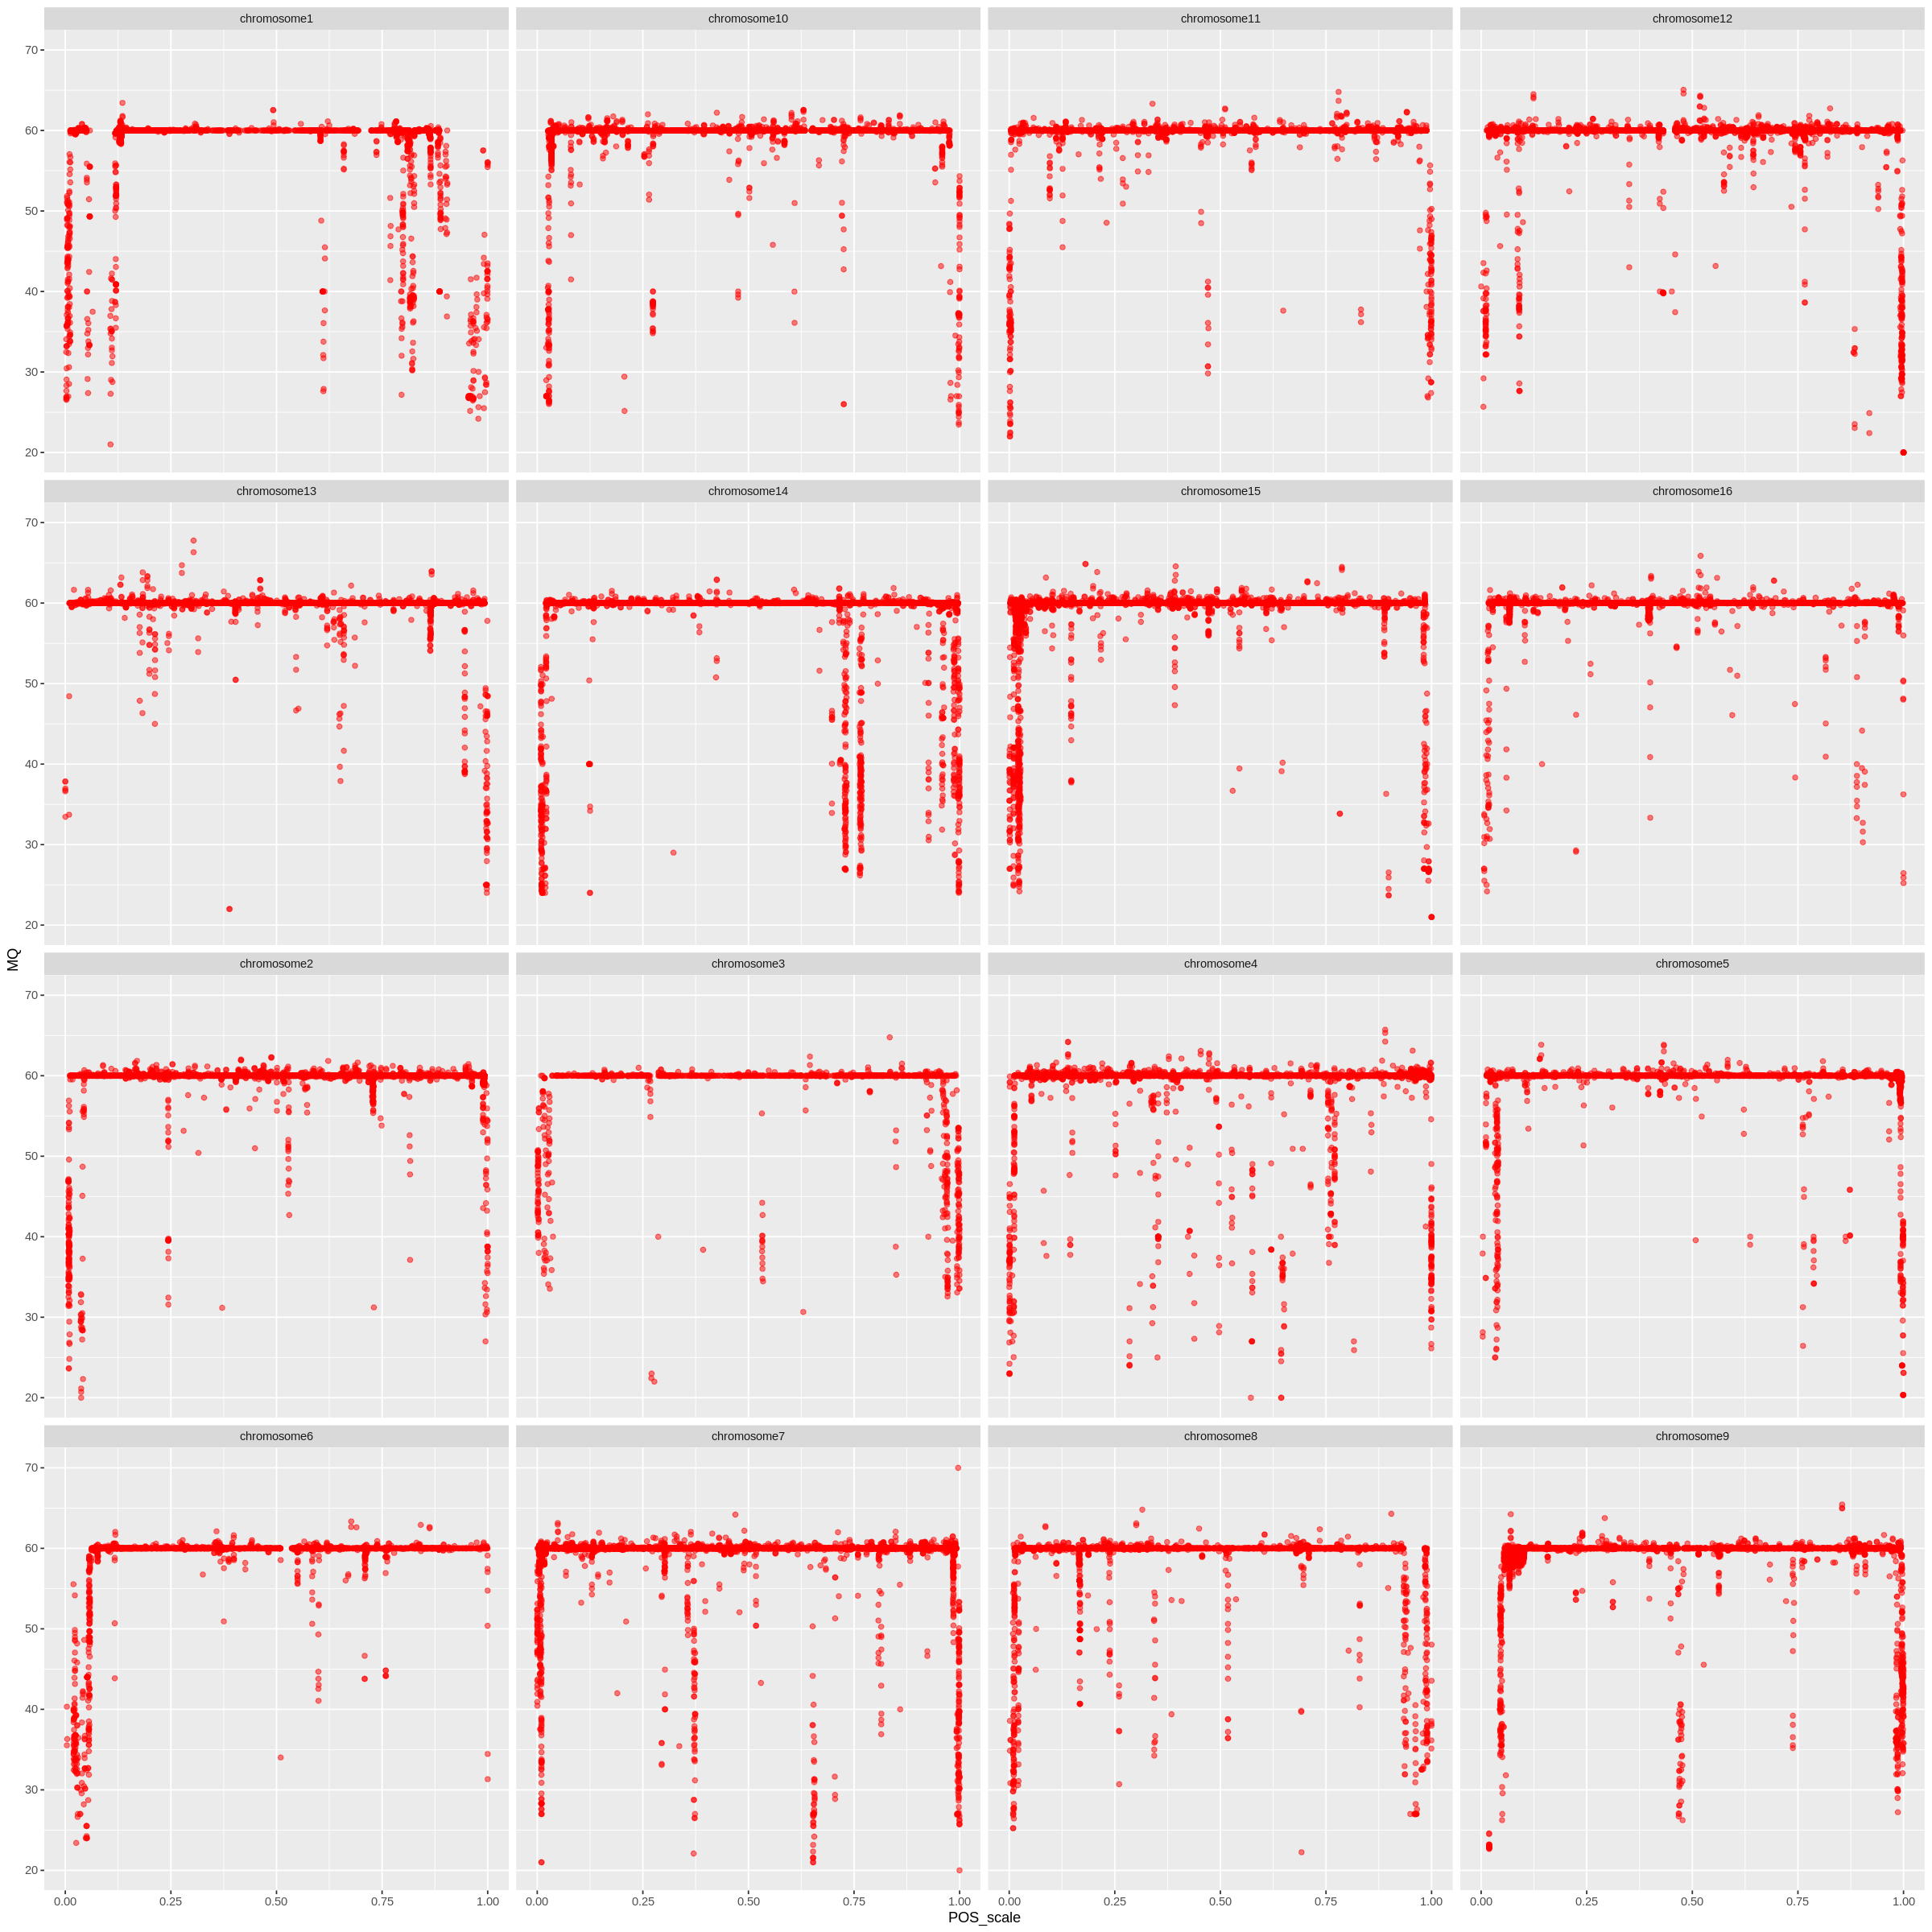

In [17]:
ggplot(df, aes(POS_scale, MQ))+
geom_point(alpha=0.5,color="red")+
facet_wrap(~CHROM)

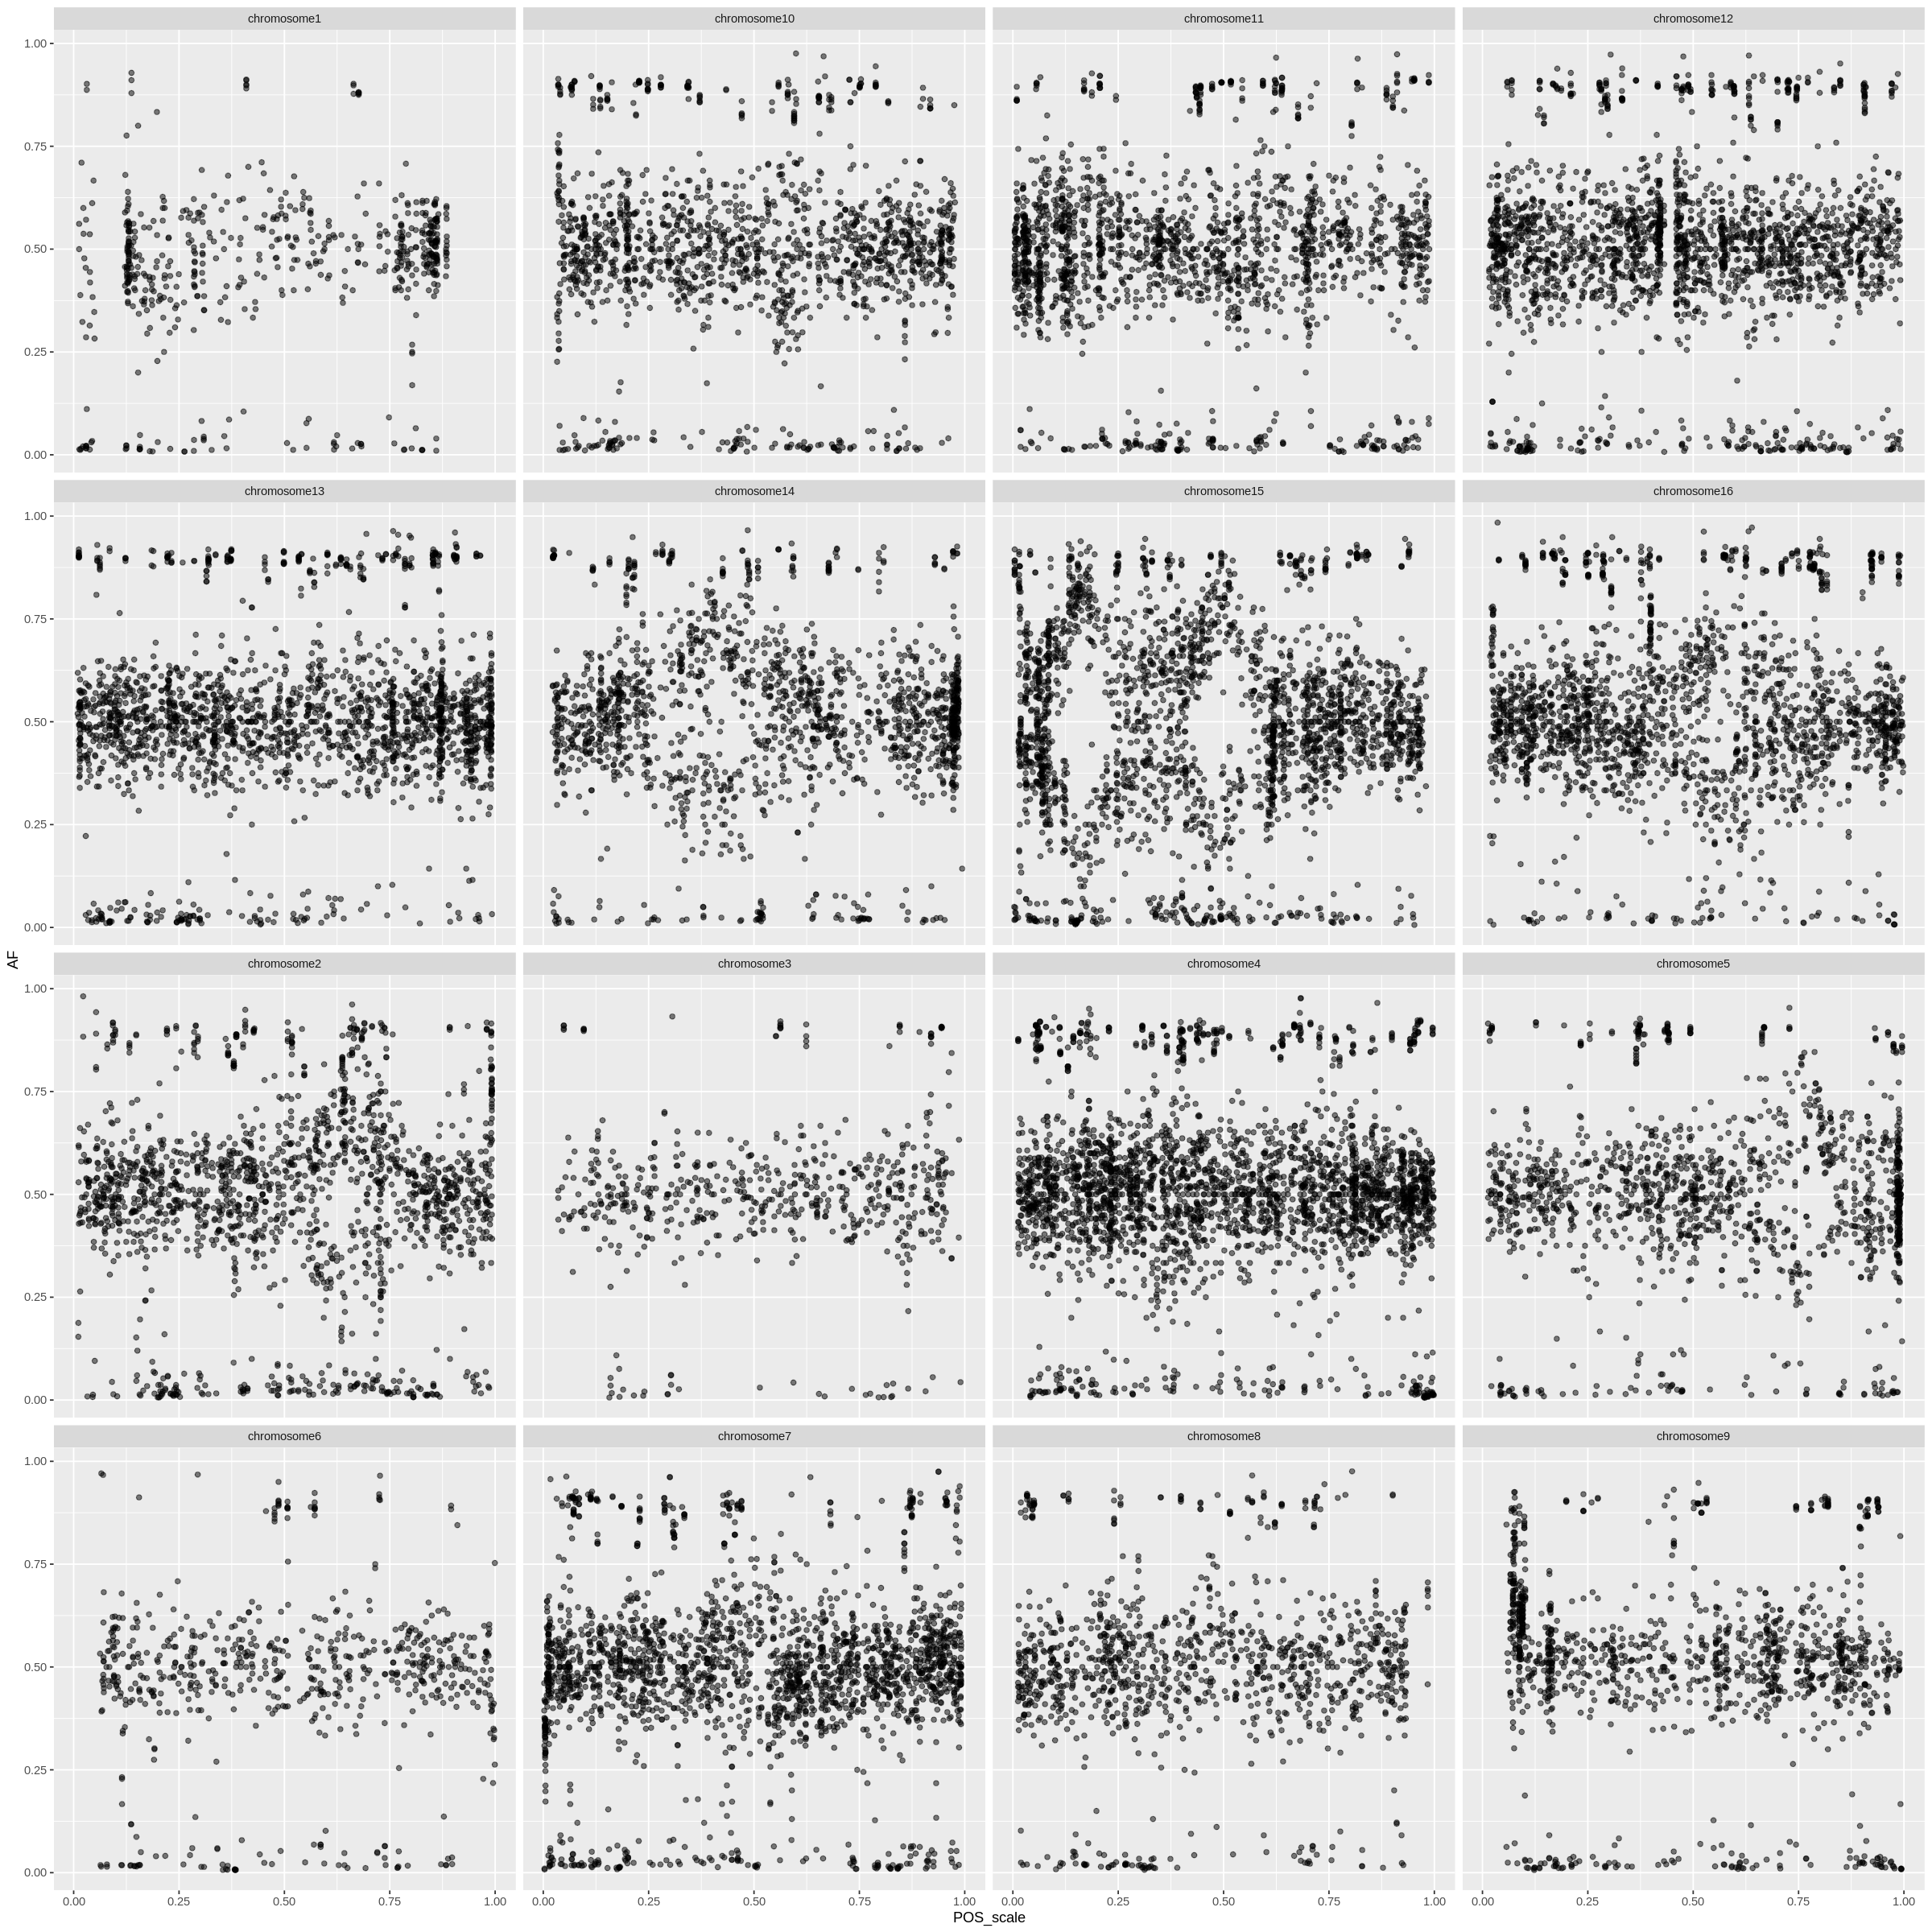

In [18]:
ggplot(subset(df, MQ>=60 & AF > 0), aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)

In [19]:
# filter for non-mean covered regions

[1] 57.69687

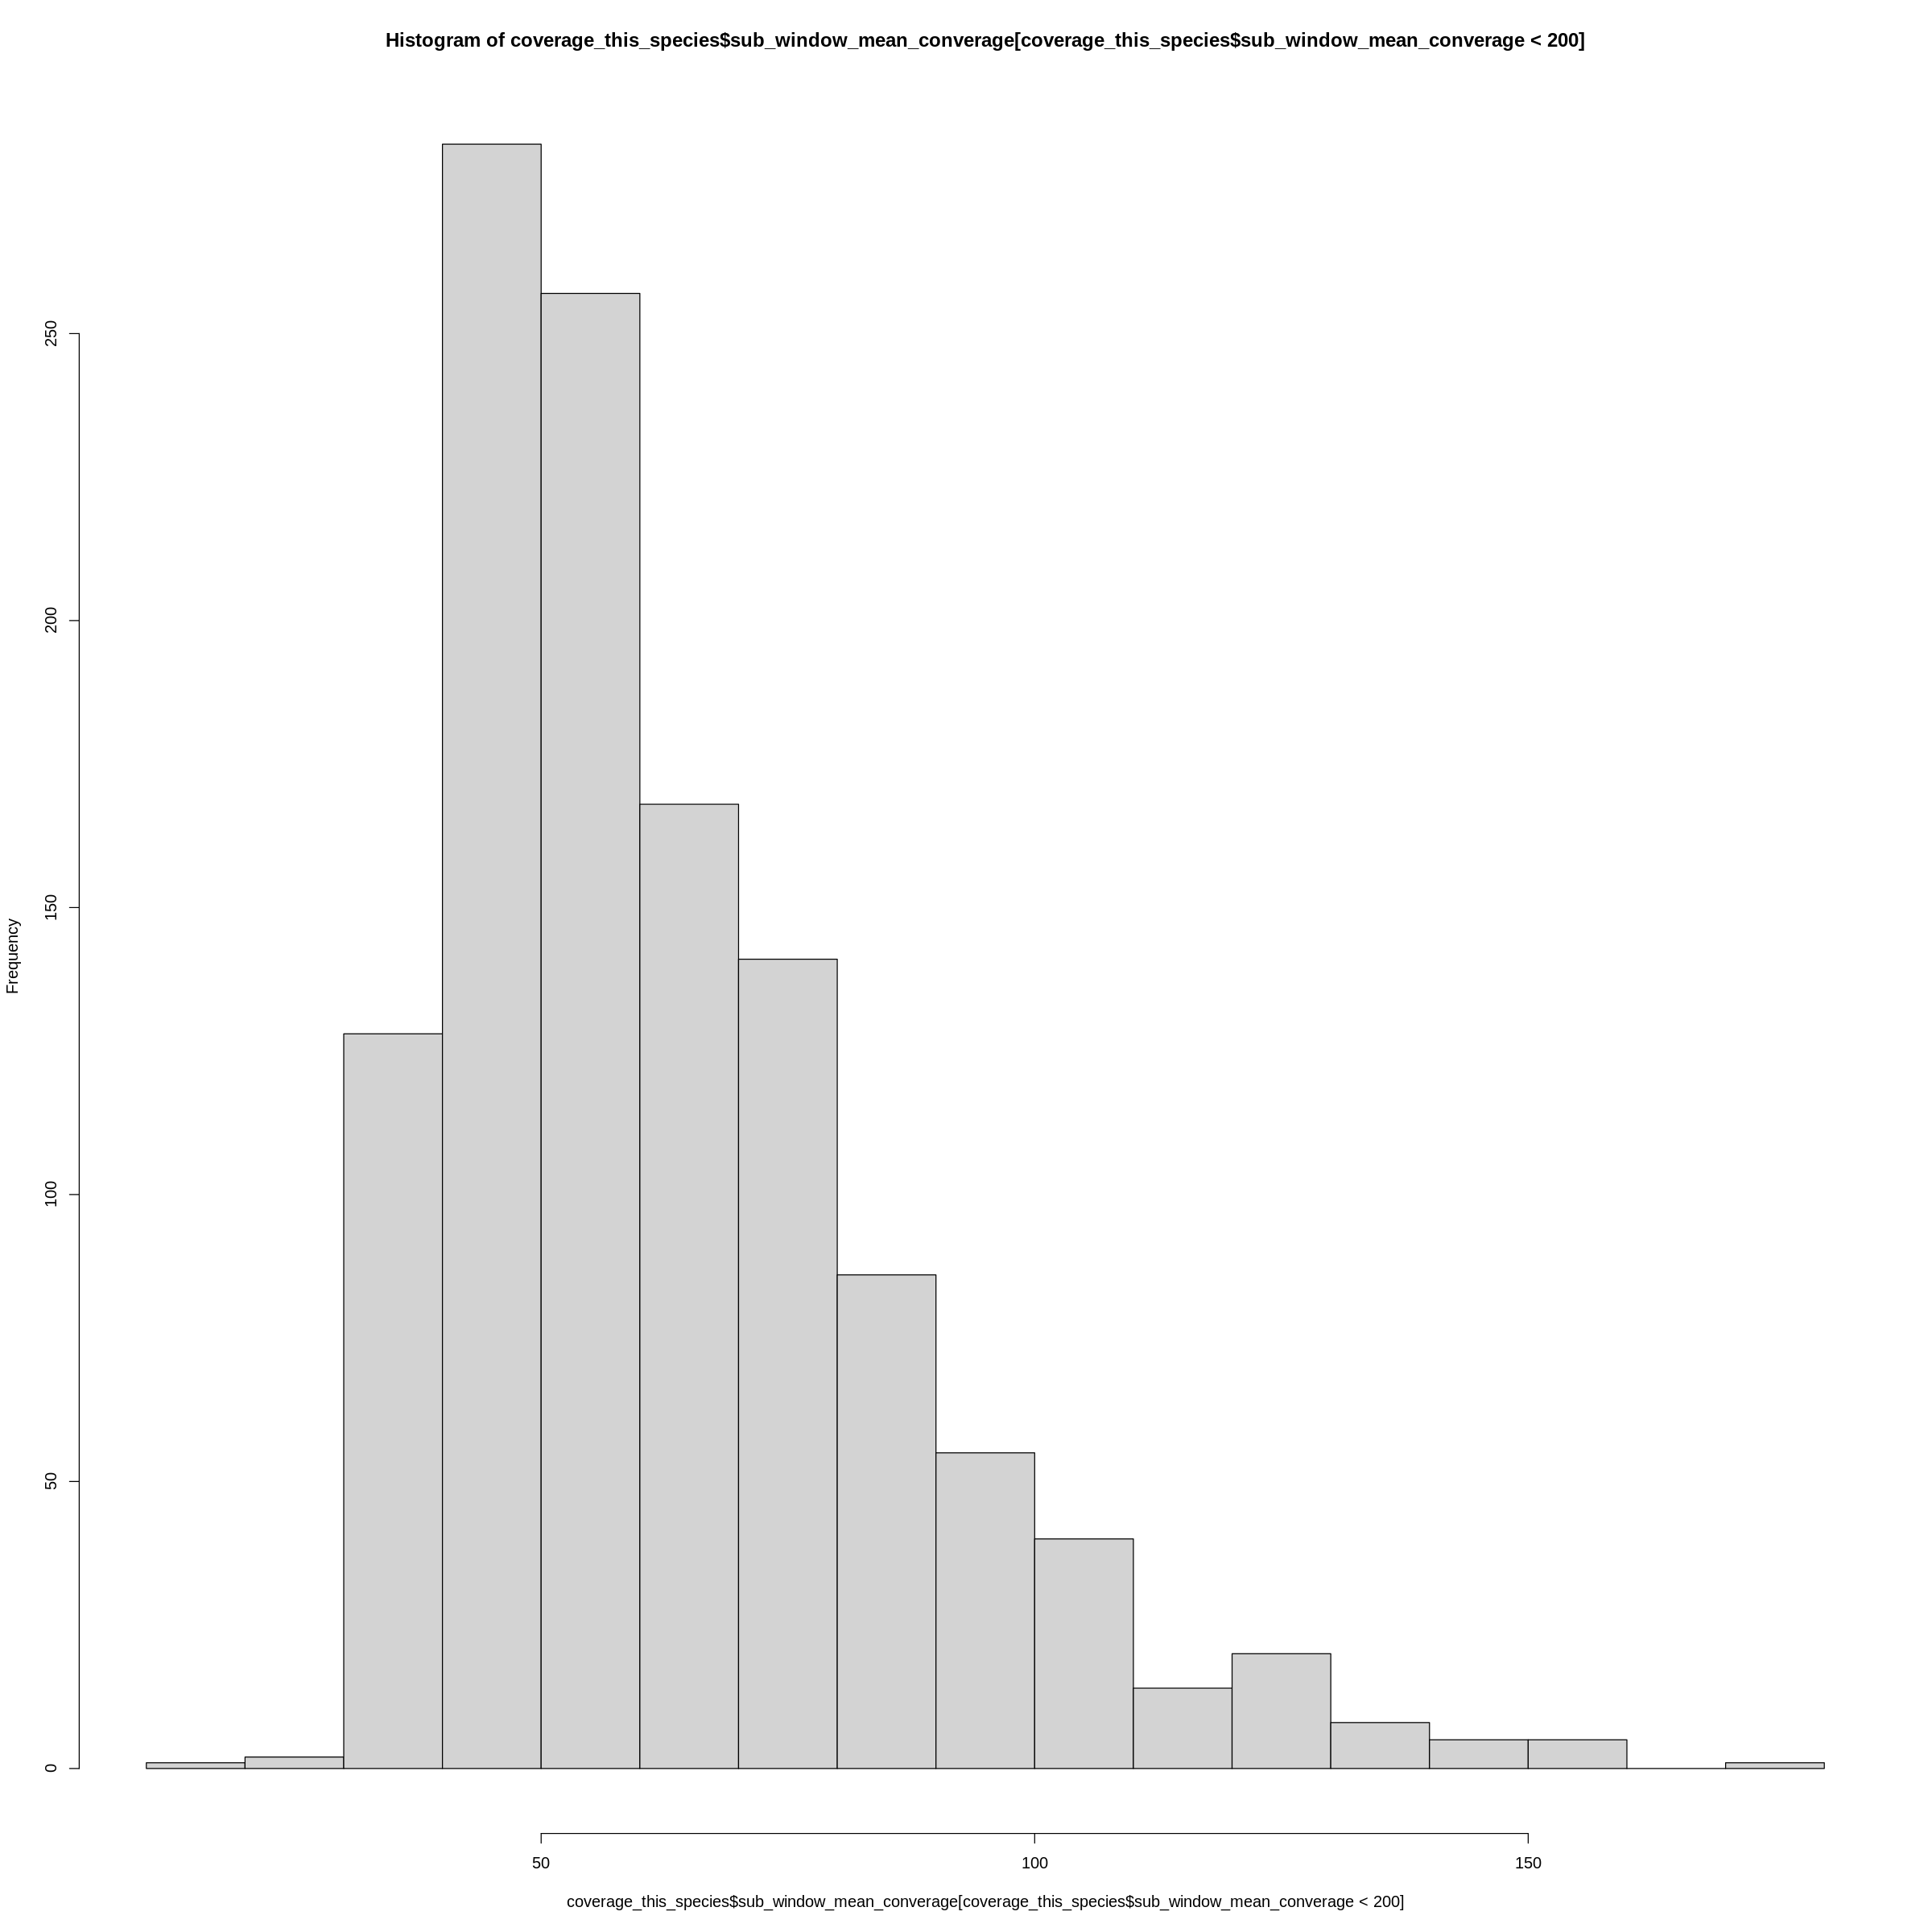

In [20]:
coverage_this_species=subset(df_coverage_chris, species=="TRDC01ACPxBFP.coverage")
median(coverage_this_species$sub_window_mean_converage)
hist(coverage_this_species$sub_window_mean_converage[coverage_this_species$sub_window_mean_converage < 200])

In [21]:
filtered_regions=subset(coverage_this_species, sub_window_mean_converage>=40 & sub_window_mean_converage<=80)

In [22]:
head(filtered_regions)
head(df)

chrom       species                Start  Stop   length_chromosome
1  chromosome1 TRDC01ACPxBFP.coverage      1  10000 230218           
3  chromosome1 TRDC01ACPxBFP.coverage  20001  30000 230218           
9  chromosome1 TRDC01ACPxBFP.coverage  80001  90000 230218           
10 chromosome1 TRDC01ACPxBFP.coverage  90001 100000 230218           
11 chromosome1 TRDC01ACPxBFP.coverage 100001 110000 230218           
15 chromosome1 TRDC01ACPxBFP.coverage 140001 150000 230218           
   sub_window_mean_converage sub_window_median_converage chrom_fct  
1  78.08585                  70                          chromosome1
3  54.09782                  45                          chromosome1
9  56.34803                  56                          chromosome1
10 50.23822                  50                          chromosome1
11 73.52525                  68                          chromosome1
15 66.39384                  64                          chromosome1

POS CHROM       AF        MQ    POS_scale   MQ_scale  MQ_scale2
1 509 chromosome1 0.0000000 32.48 0.002215799 -23.05299 -2.621362
2 561 chromosome1 0.7708333 34.07 0.002442167 -21.46299 -2.440563
3 610 chromosome1 0.0000000 26.75 0.002655476 -28.78299 -3.272922
4 618 chromosome1 0.6923077 26.54 0.002690302 -28.99299 -3.296801
5 623 chromosome1 0.5833333 26.63 0.002712068 -28.90299 -3.286567
6 627 chromosome1 0.6363636 26.91 0.002729481 -28.62299 -3.254729

In [23]:
IsLocusInGoodRegion=function(x){
    return(sum(df$POS[x] >= filtered_regions$Start[filtered_regions$chrom==df$CHROM[x]] & 
               df$POS[x] <= filtered_regions$Stop[filtered_regions$chrom==df$CHROM[x]]))
}

In [24]:
summary(unlist(lapply(1:nrow(df), IsLocusInGoodRegion)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.7004  1.0000  1.0000 

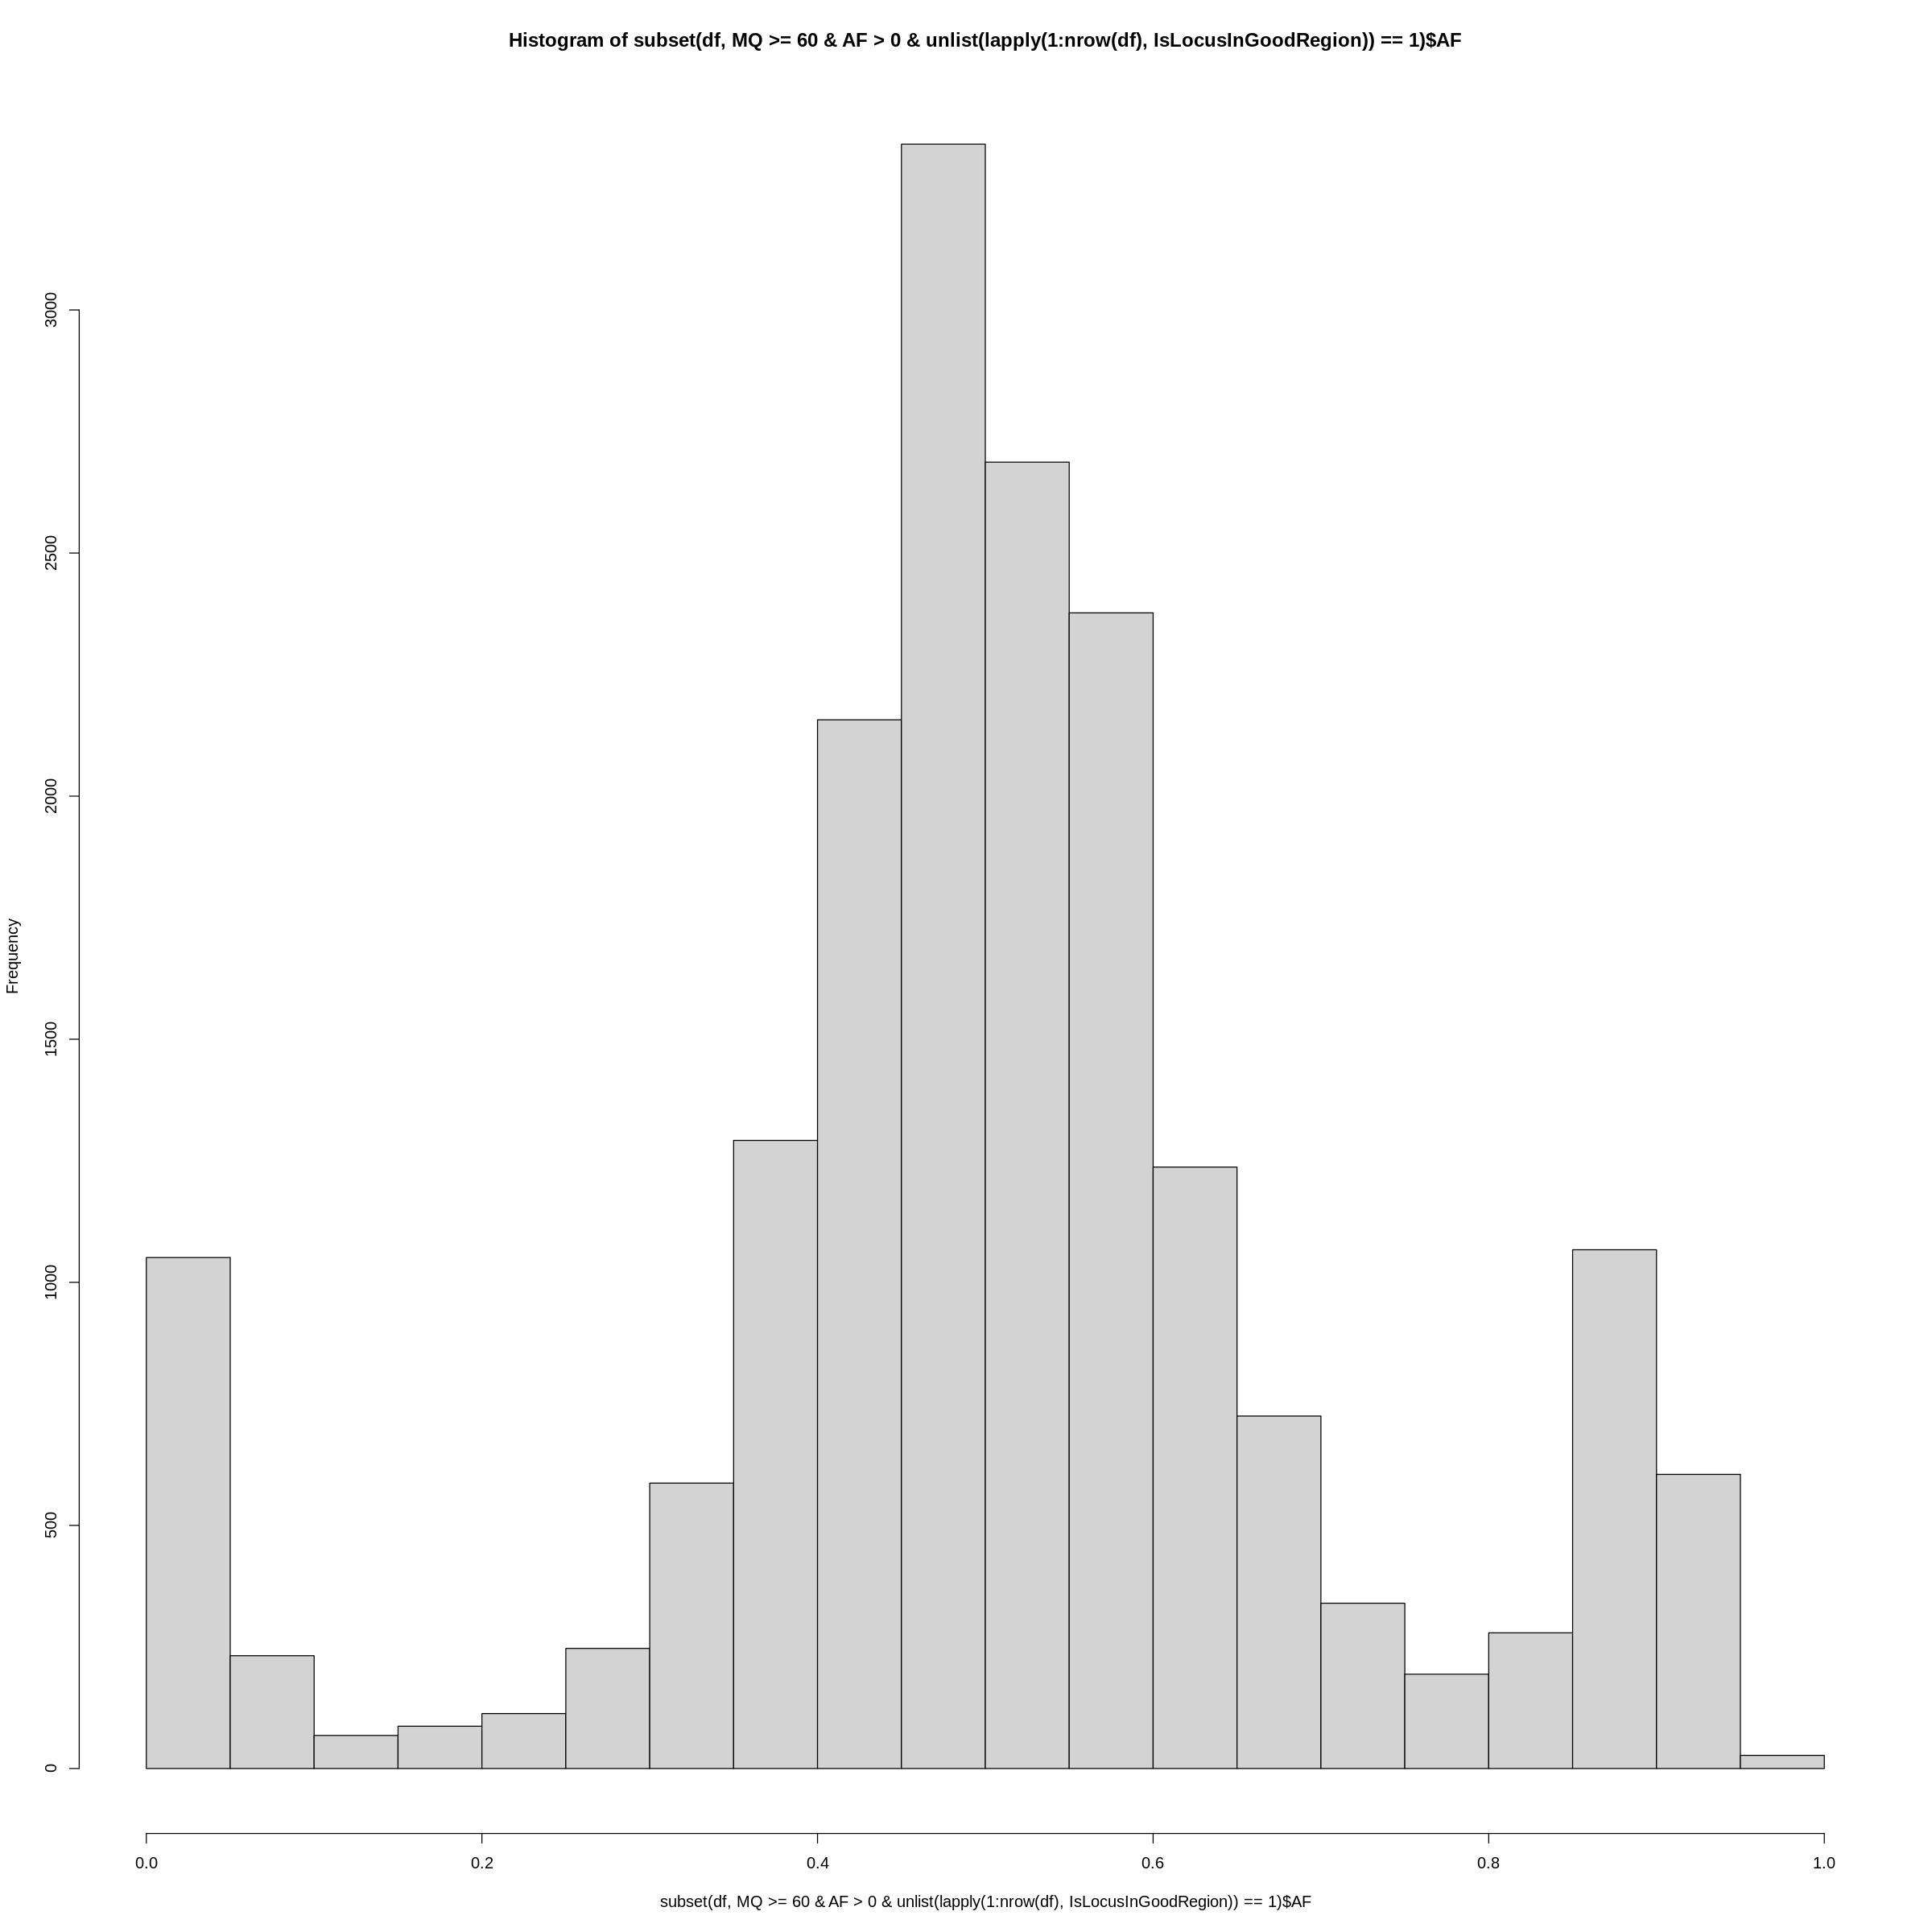

In [25]:
hist(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1)$AF)

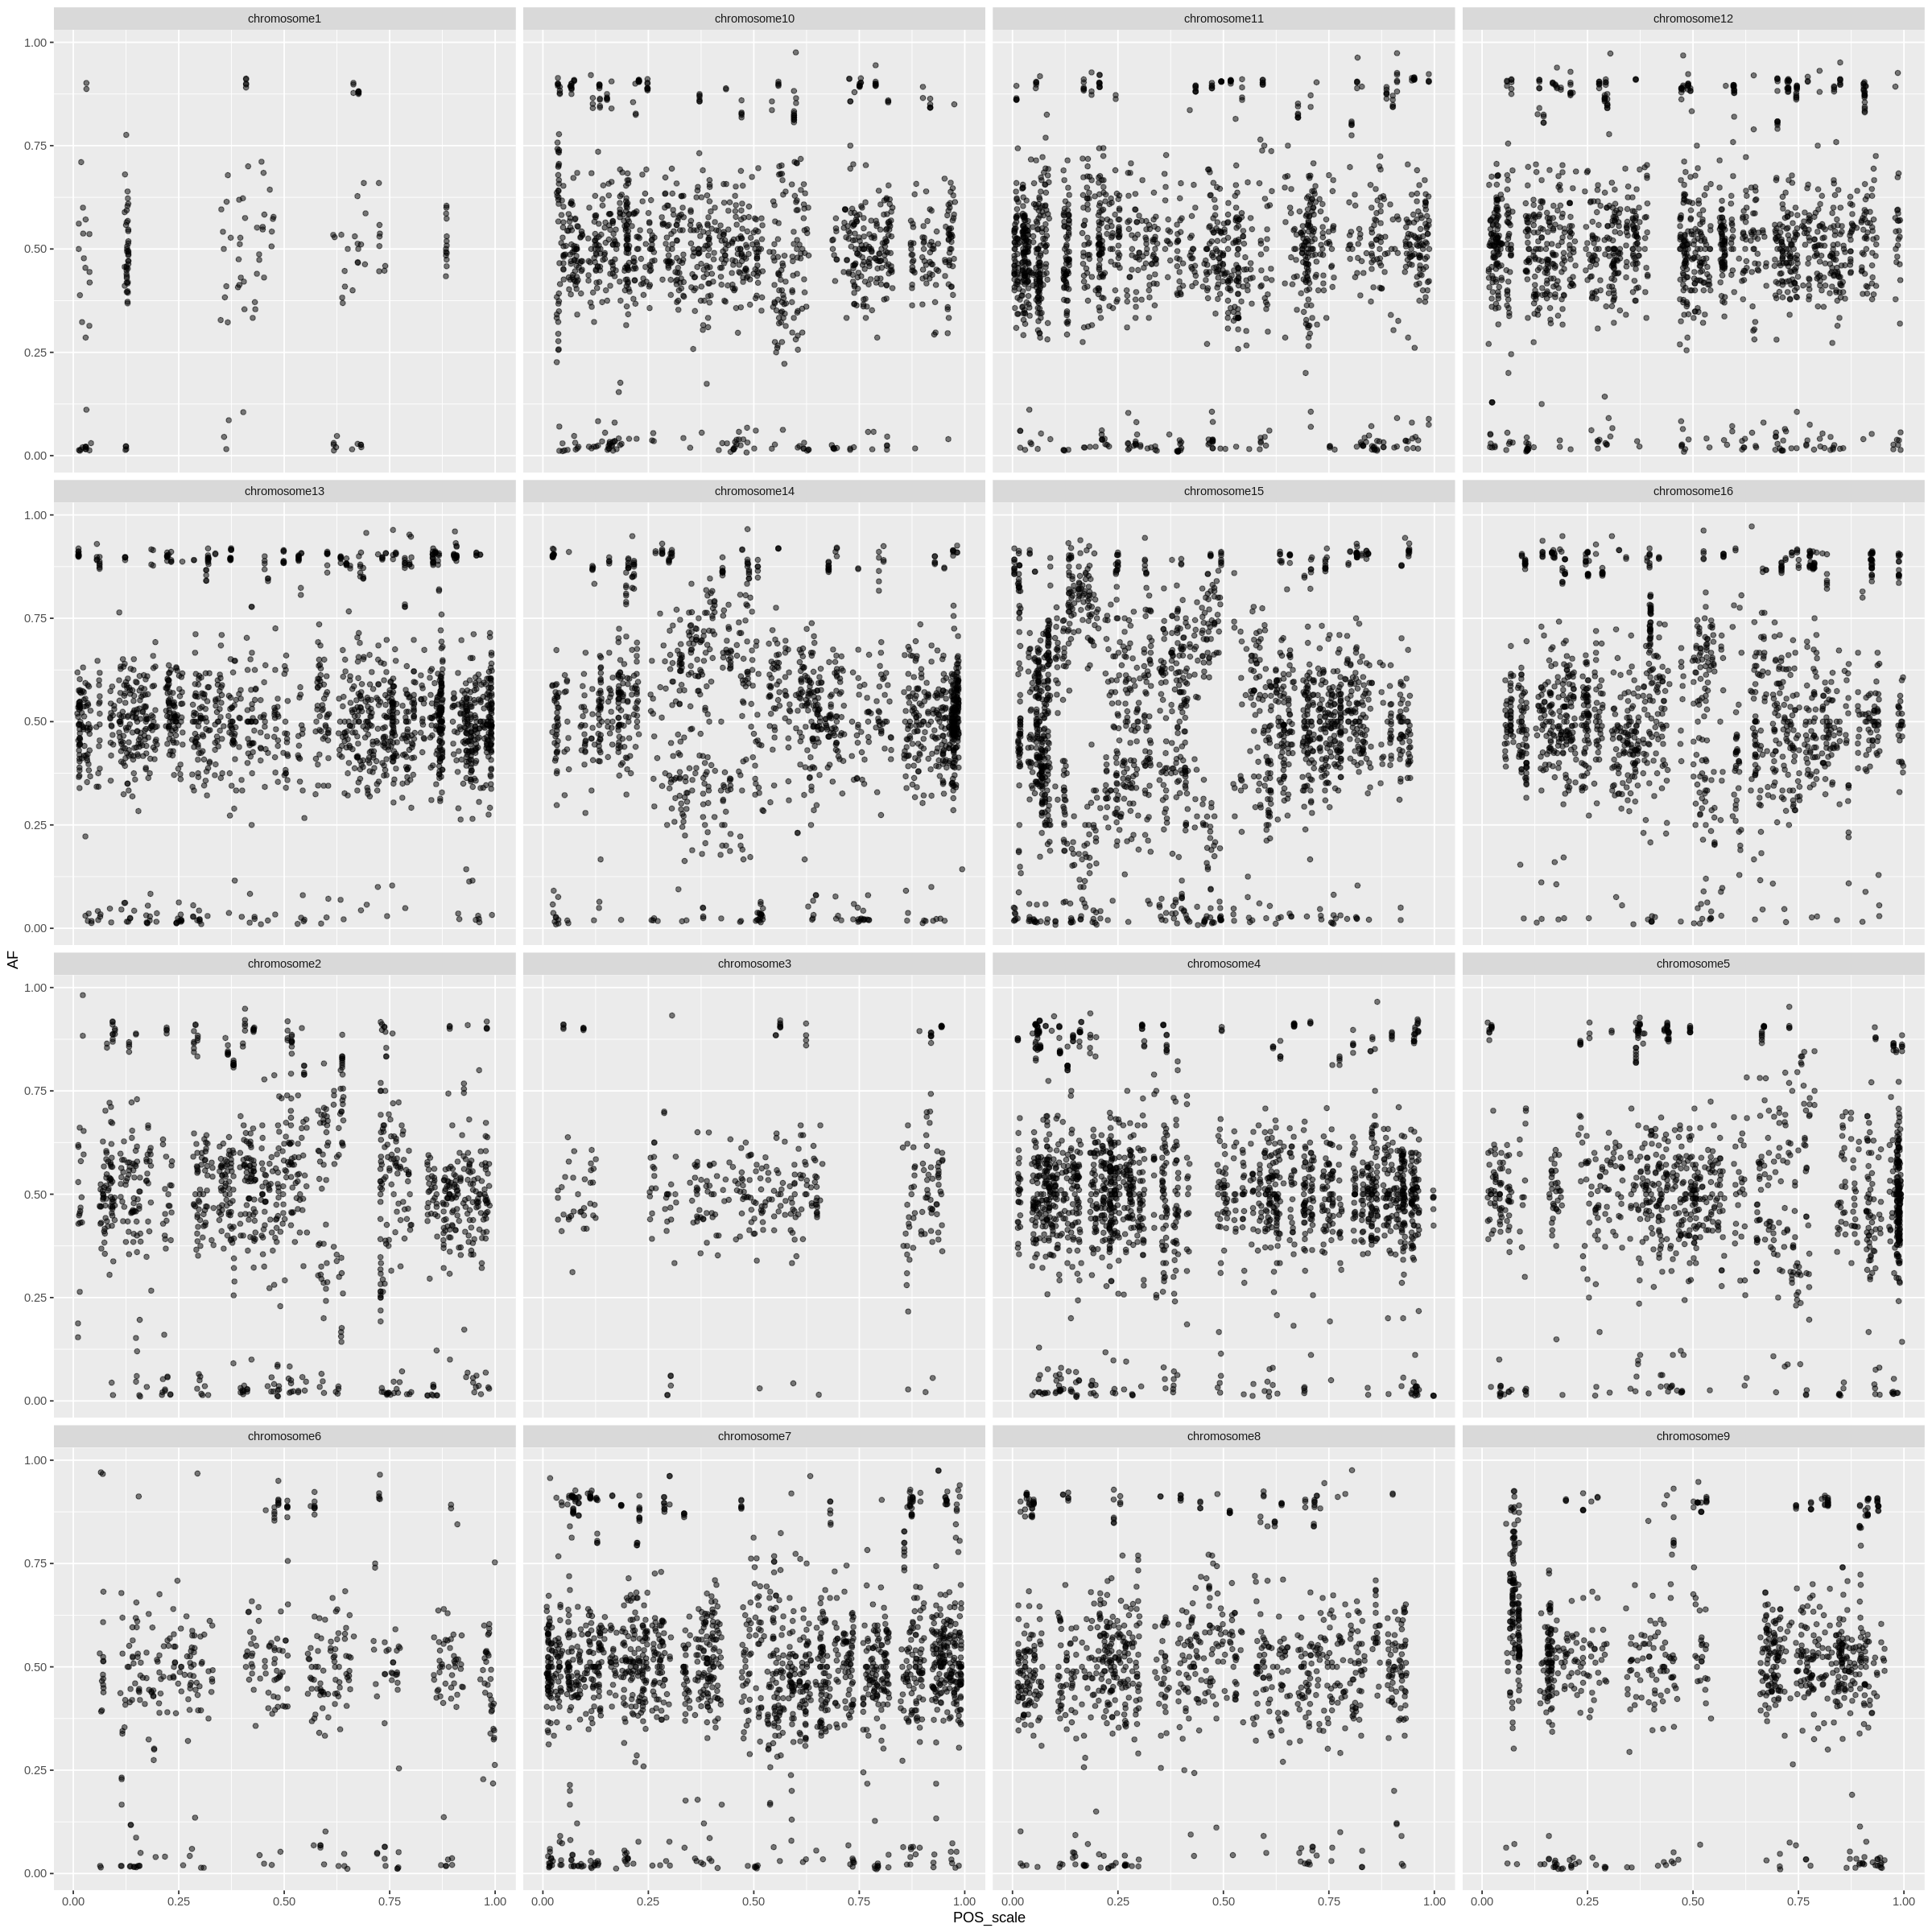

In [26]:
ggplot(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1), aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)

In [31]:
head(df)

POS CHROM       AF        MQ    POS_scale   MQ_scale  MQ_scale2
1 509 chromosome1 0.0000000 32.48 0.002215799 -23.05299 -2.621362
2 561 chromosome1 0.7708333 34.07 0.002442167 -21.46299 -2.440563
3 610 chromosome1 0.0000000 26.75 0.002655476 -28.78299 -3.272922
4 618 chromosome1 0.6923077 26.54 0.002690302 -28.99299 -3.296801
5 623 chromosome1 0.5833333 26.63 0.002712068 -28.90299 -3.286567
6 627 chromosome1 0.6363636 26.91 0.002729481 -28.62299 -3.254729

In [35]:
homozygous_gt=fread("./homozygous_gt.csv.gz", data.table=FALSE)
homozygous_gt_cross=homozygous_gt[,c("POS","CHROM","ACP","BFP")]
gt=fread("./gt.csv.gz", data.table=FALSE)
gt_cross=gt[,c("POS","CHROM","ACP","BFP")]


head(homozygous_gt_cross)

head(gt_cross)

POS CHROM       ACP BFP
1 33  chromosome1 NA  NA 
2 56  chromosome1 NA  NA 
3 63  chromosome1 NA  NA 
4 65  chromosome1 NA  NA 
5 71  chromosome1 NA  NA 
6 83  chromosome1 NA  NA

POS CHROM       ACP BFP
1 33  chromosome1        
2 56  chromosome1        
3 63  chromosome1        
4 65  chromosome1        
5 71  chromosome1        
6 83  chromosome1

In [36]:
unique(gt_cross$ACP)

[1] ""    "0/0" "1/1" "0/1" "2/2" "1/2" "0/3" "4/4" "2/3" "3/3" "0/2" "5/5"
[13] "0/6" "0/4" "1/3" "6/6" "0/5" "3/4" "4/6" "1/5" "3/6" "3/5" "2/4" "4/5"
[25] "2/6" "1/4" "1/6"

In [34]:
head(homozygous_gt)

POS CHROM       ACP...3 BFP...4 BAP...5 CMP...6 CCD...7 CPG...8 ATE...9
1 33  chromosome1 NA      NA      NA      NA      NA      NA      NA     
2 56  chromosome1 NA      NA      NA      NA      NA      NA      NA     
3 63  chromosome1 NA      NA      NA      NA      NA      NA      NA     
4 65  chromosome1 NA      NA      NA      NA      NA      NA      NA     
5 71  chromosome1 NA      NA      NA      NA      NA      NA      NA     
6 83  chromosome1 NA      NA      NA      NA      NA      NA      NA     
  SACE_YCR...10 <U+22EF>   CPG...23 ATE...24 SACE_YCR...25 ACK...26 ACV...27
1 NA            <U+22EF> NA       NA       NA            NA       NA      
2 NA            <U+22EF> NA       NA       NA            NA       NA      
3 NA            <U+22EF> NA       NA       NA            NA       NA      
4 NA            <U+22EF> NA       NA       NA            NA       NA      
5 NA            <U+22EF> NA       NA       NA            NA       NA      
6 NA            <U+22EF> NA       NA       NA            NA       NA      
  AKE...28 BAH...29 CGD...30 ANG...31 CEI...32
1 NA       NA       NA       NA       NA      
2 NA       NA       NA       NA       NA      
3 NA       NA       NA       NA       NA      
4 NA       NA       NA       NA       NA      
5 NA       NA       NA       NA       NA      
6 NA       NA       NA       NA       NA

In [37]:
nrow(gt_cross)==nrow(homozygous_gt_cross)

[1] TRUE

In [38]:
homozygous_gt_cross$OppositeHomo=!is.na(homozygous_gt_cross[,3]) & !is.na(homozygous_gt_cross[,4]) & homozygous_gt_cross[,3] == TRUE & homozygous_gt_cross[,4] == TRUE &
gt_cross[,3] != homozygous_gt_cross[,3]

In [39]:
summary(homozygous_gt_cross$OppositeHomo)

   Mode   FALSE    TRUE 
logical   89619 1665247 

In [40]:
head(homozygous_gt_cross)

POS CHROM       ACP BFP OppositeHomo
1 33  chromosome1 NA  NA  FALSE       
2 56  chromosome1 NA  NA  FALSE       
3 63  chromosome1 NA  NA  FALSE       
4 65  chromosome1 NA  NA  FALSE       
5 71  chromosome1 NA  NA  FALSE       
6 83  chromosome1 NA  NA  FALSE

In [42]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [43]:
df=left_join(df, homozygous_gt_cross[,c("POS","CHROM","OppositeHomo")], by=c("POS","CHROM"))
head(df)

POS CHROM       AF        MQ    POS_scale   MQ_scale  MQ_scale2 OppositeHomo
1 509 chromosome1 0.0000000 32.48 0.002215799 -23.05299 -2.621362 FALSE       
2 561 chromosome1 0.7708333 34.07 0.002442167 -21.46299 -2.440563 FALSE       
3 610 chromosome1 0.0000000 26.75 0.002655476 -28.78299 -3.272922 FALSE       
4 618 chromosome1 0.6923077 26.54 0.002690302 -28.99299 -3.296801 FALSE       
5 623 chromosome1 0.5833333 26.63 0.002712068 -28.90299 -3.286567 FALSE       
6 627 chromosome1 0.6363636 26.91 0.002729481 -28.62299 -3.254729 FALSE

In [44]:
unique(df$OppositeHomo)

[1] FALSE  TRUE    NA

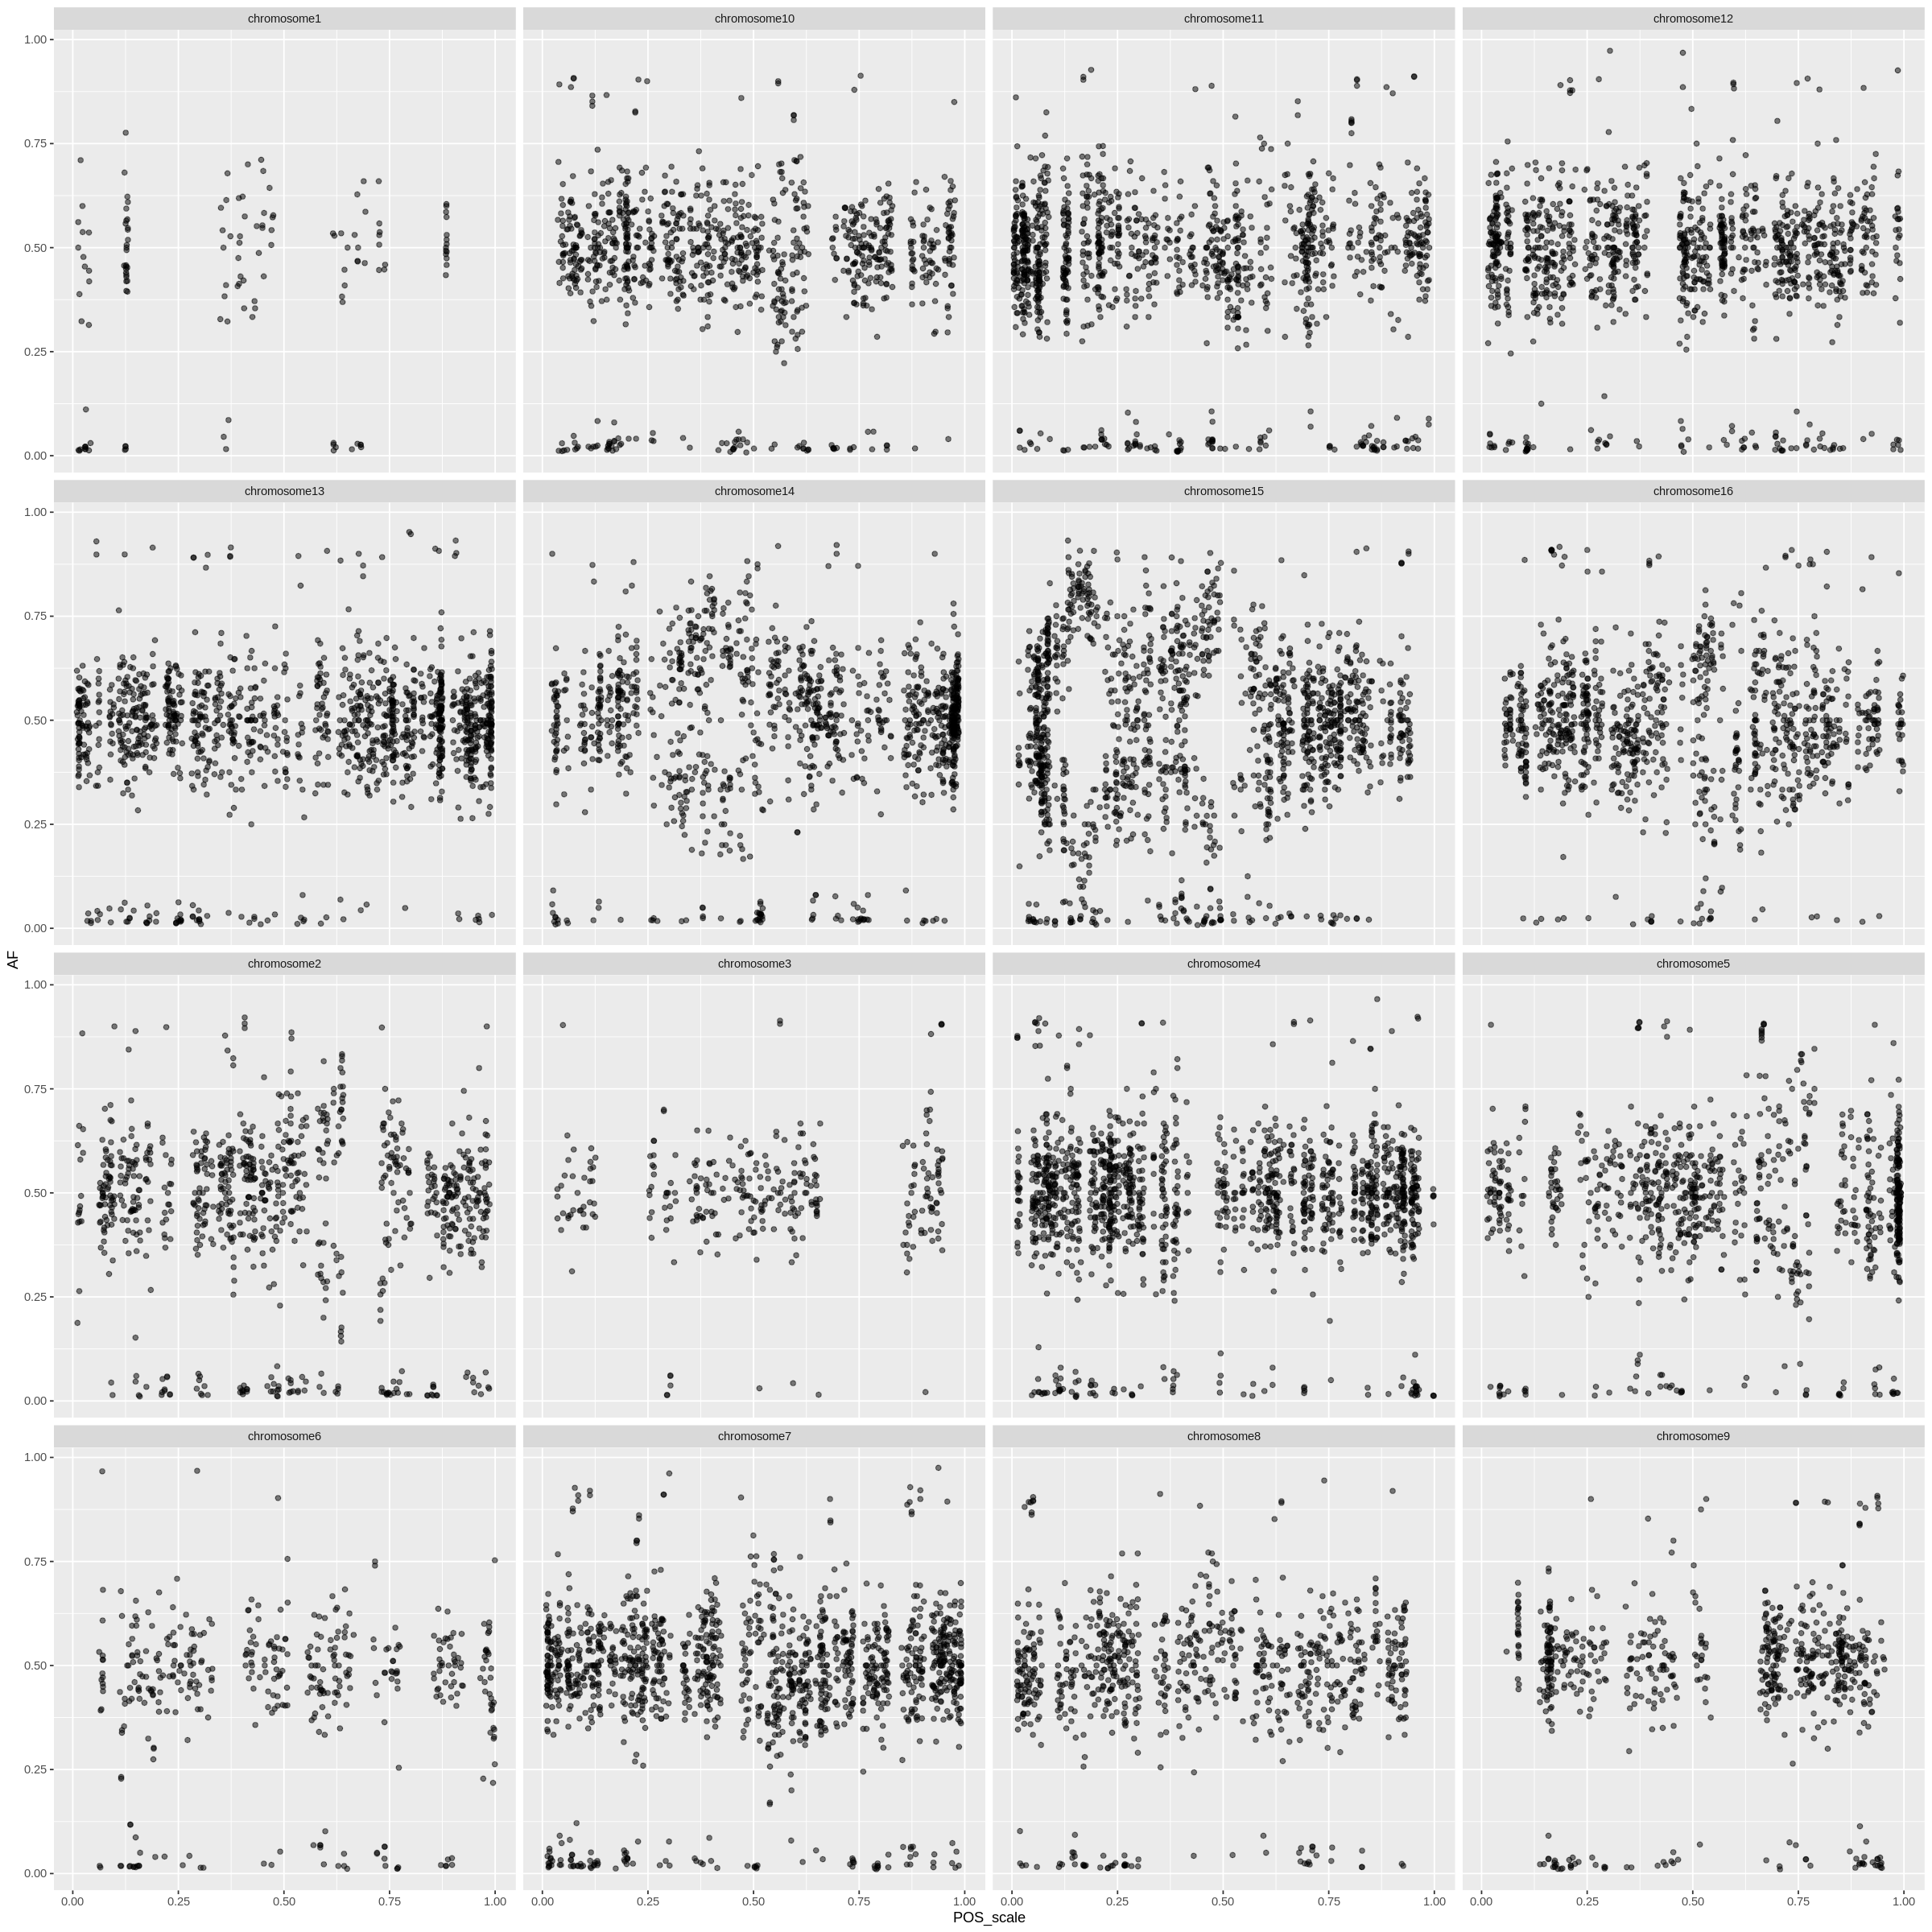

In [45]:
ggplot(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1 & !is.na(OppositeHomo) & OppositeHomo == TRUE), aes(POS_scale, AF))+
geom_point(alpha=0.5)+
facet_wrap(~CHROM)